In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa

In [2]:
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

Using TensorFlow backend.


In [3]:
import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config

In [4]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1




In [5]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d = 1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

def envelope (y,rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window = int(rate/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
            
    return mask

In [6]:
df = pd.read_csv('/Users/Aristo/Documents/CSAI Master/2nd block/Machiene learning/Challenge/mlchallenge-oct-2019/train.csv')

In [7]:
df.set_index('path', inplace=True)

In [8]:
for f in df.index:
    rate, signal = wavfile.read('wav/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

In [10]:
rate

16000

In [9]:
classes = list(np.unique(df.word))

In [12]:
class_dist = df.groupby(['word'])['length'].mean()
class_dist

word
backward    0.985866
bed         0.969748
bird        0.970034
cat         0.972057
dog         0.971182
down        0.983438
eight       0.980606
five        0.984074
follow      0.981373
forward     0.983982
four        0.983254
go          0.979027
happy       0.974653
house       0.974648
learn       0.974589
left        0.984452
marvin      0.976933
nine        0.985261
no          0.978838
off         0.985107
on          0.981709
one         0.978251
right       0.982133
seven       0.984938
sheila      0.977098
six         0.987554
stop        0.984114
three       0.983360
tree        0.970351
two         0.981811
up          0.975137
visual      0.982601
wow         0.971456
yes         0.982973
zero        0.987005
Name: length, dtype: float64

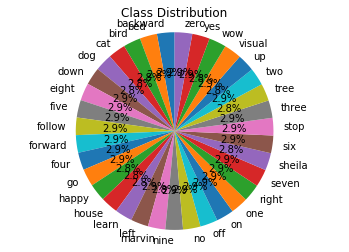

In [13]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y = 1.00)
ax.pie(class_dist, labels = class_dist.index, autopct = '%1.1f%%', shadow = False, startangle = 90)
ax.axis('equal')
plt.show
df.reset_index(inplace = True)

In [14]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

In [15]:
for c in classes:
    wav_file = df[df.word == c].iloc[0,0]
    signal, rate = librosa.load('wav/'+wav_file, sr=16000)
    mask = envelope(signal, rate, 0.001)
    signal = signal[mask]
    signals[c] = signal 
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 52, nfft = 1024).T
    fbank[c] = bank
    
    mel = mfcc(signal[:rate], rate, numcep = 26, nfilt = 52, nfft = 1024).T
    mfccs[c] = mel

In [16]:
len(mfccs)

35

<function matplotlib.pyplot.show(*args, **kw)>

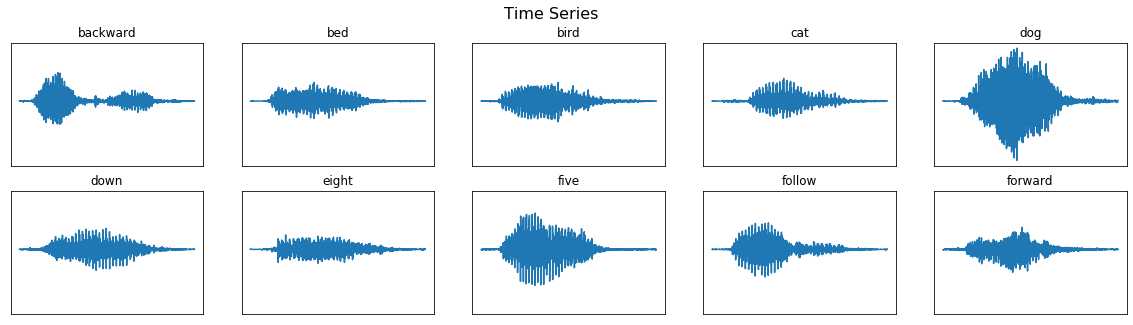

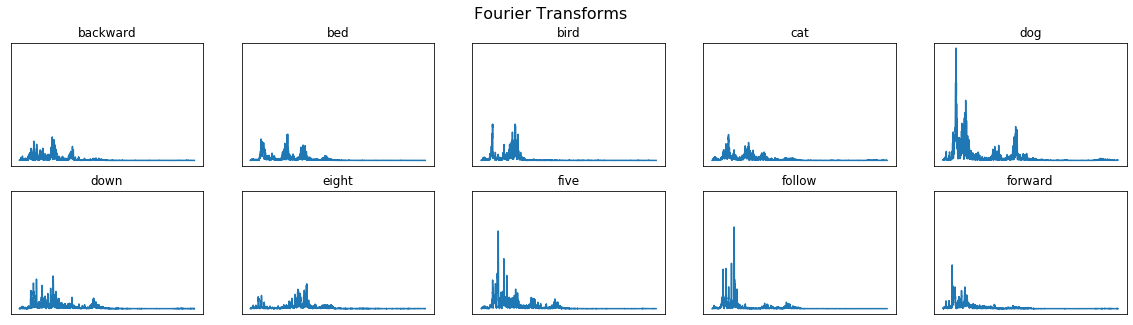

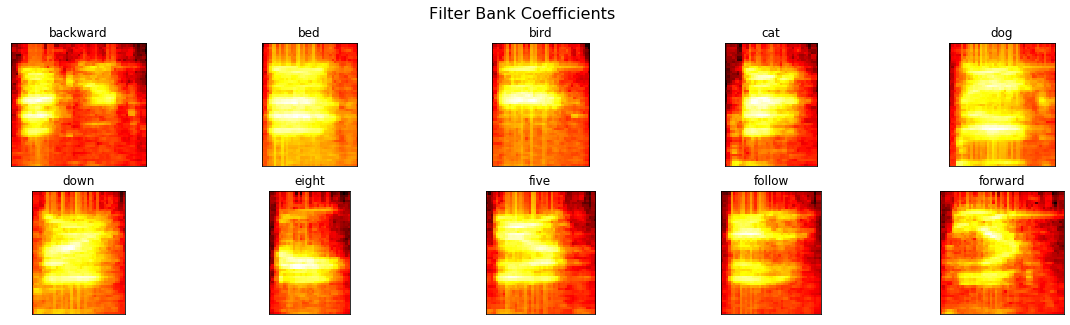

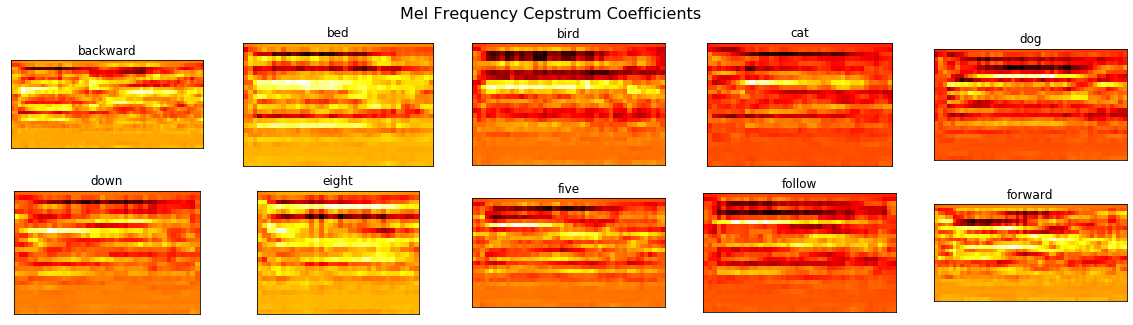

In [17]:
plot_signals(signals)
plt.show

plot_fft(fft)
plt.show

plot_fbank(fbank)
plt.show

plot_mfccs(mfccs)
plt.show



In [18]:
if len(os.listdir('clean')) == 0:
    for f in tqdm(df.path):
        signal, rate = librosa.load('wav/'+f, sr= 16000)
        mask = envelope(signal, rate, 0.001)
        wavfile.write(filename = 'clean/'+f, rate = rate, data = signal[mask])

In [19]:
def check_data():
    if os.path.isfile(config.p_path):
        print ('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            
            return tmp
    else:
        return None
        

In [ ]:
# def build_rand_feat():
    
#     tmp = check_data()
#     if tmp:
#         return tmp.data[0], tmp.data[1]
    
#     X = []
#     y = []
#     _min, _max = float('inf'), -float('inf')
    
#     for _ in tqdm(range(n_samples)):
#         rand_class = np.random.choice(class_dist.index, p = prob_dist)
#         file = np.random.choice(df[df.word == rand_class].index)
#         rate, wav = wavfile.read('clean/'+file)
#         label = df.at[file,'word']
        
#         rand_index = np.random.randint(0, wav.shape[0]-config.step)
        
#         sample = wav[rand_index:rand_index+config.step]
#         X_sample = mfcc(sample, rate, numcep = config.nfeat, nfilt = config.nfilt, nfft = config.nfft)
#         _min = min(np.amin(X_sample), _min)
#         _max = max(np.amax(X_sample), _max)
#         X.append(X_sample)
#         y.append(classes.index(label))
        
#     config.min = _min
#     config.max = _max
    
#     X,y = np.array(X), np.array(y)
#     X = (X - _min)/(_max - _min)
#     if config.mode == 'conv':
#         X= X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
#     elif config.mode == 'time':
#         X= X.reshape(X.shape[0], X.shape[1], X.shape[2])
        
#     y = to_categorical(y, num_classes=35)
    
#     config.data = (X,y)
    
#     with open (config.p_path, 'wb') as handle:
#         pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#     return X,y

In [20]:
def build_rand_feat():
    
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    
    
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.word == rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = df.at[file,'word']
        
        if wav.shape[0]<config.step:
            pass
        else:
            rand_index = np.random.randint(0, wav.shape[0]-config.step)

            sample = wav[rand_index:rand_index+config.step]
            X_sample = mfcc(sample, rate, numcep = config.nfeat, nfilt = config.nfilt, nfft = config.nfft)
            _min = min(np.amin(X_sample), _min)
            _max = max(np.amax(X_sample), _max)
            X.append(X_sample)
            y.append(classes.index(label))
        
    config.min = _min
    config.max = _max
    
    X,y = np.array(X), np.array(y)
    X = (X - _min)/(_max - _min)
    if config.mode == 'conv':
        X= X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X= X.reshape(X.shape[0], X.shape[1], X.shape[2])
        
    y = to_categorical(y, num_classes=35)
    
    config.data = (X,y)
    
    with open (config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return X,y


In [ ]:
# def get_conv_model():
#     model = Sequential()
#     #model.add(Conv2D(64,(3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
#     model.add(Conv2D(128,(3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
#     model.add(Conv2D(256,(3, 3), activation='relu', strides=(1, 1), padding='same'))
#     model.add(Conv2D(512,(3, 3), activation='relu', strides=(1, 1), padding='same'))
#     model.add(MaxPool2D((2,2)))
#     model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(35, activation='softmax'))
#     model.summary()
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
#     return model

In [ ]:
#40% val acc

def get_conv_model():
    model = Sequential()
    #model.add(Conv2D(40,(3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    #model.add(Conv2D(80,(3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(16,(1, 1), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32,(3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(Conv2D(64,(5, 5), activation='relu', strides=(1, 1), padding='same'))
    model.add(Conv2D(128,(7, 7), activation='relu', strides=(1, 1), padding='same'))
    #model.add(Conv2D(128,(7, 7), activation='relu', strides=(1, 1), padding='same'))
#     model.add(Conv2D(128,(5, 5), activation='relu', strides=(1, 1), padding='same'))
#     model.add(Conv2D(256,(7, 7), activation='relu', strides=(1, 1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.05))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(35, activation='softmax'))
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [21]:
#test version

def get_conv_model():
    model = Sequential()
    #model.add(Conv2D(40,(3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    #model.add(Conv2D(80,(3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(16,(1, 1), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32,(3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(Conv2D(64,(3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(Conv2D(128,(5, 5), activation='relu', strides=(1, 1), padding='same'))
    #model.add(Conv2D(128,(7, 7), activation='relu', strides=(1, 1), padding='same'))
#     model.add(Conv2D(128,(5, 5), activation='relu', strides=(1, 1), padding='same'))
#     model.add(Conv2D(256,(7, 7), activation='relu', strides=(1, 1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.05))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(35, activation='softmax'))
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [ ]:
def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.05))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(TimeDistributed(Dense(128, activation='relu')))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(Flatten())
    model.add(Dense(35, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [ ]:
# class Config:
#     def __init__(self, mode = 'conv', nfilt = 26, nfeat = 13, nfft = 4096, rate = 4000):
#         self.mode = mode
#         self.nfilt = nfilt
#         self.nfeat = nfeat
#         self.nfft = nfft
#         self.rate = rate
#         self.step = int(rate/10)

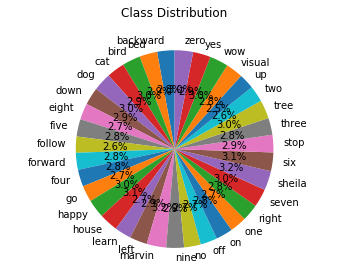

In [22]:
df = pd.read_csv('train.csv')
df.set_index('path', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.word))
class_dist = df.groupby(['word'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p = prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()



In [ ]:
config = Config(mode='conv')

if config.mode == 'conv':
    X,y = build_rand_feat()
    
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
    
elif config.mode == 'time':
    X,y = build_rand_feat()
    
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    
    
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor = 'val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False, period=1)

X,X_test, y, y_test = train_test_split(X,y, test_size=0.1)

model.fit(X,y, epochs=10, batch_size=32, shuffle=True, class_weight=class_weight, validation_split=0.1, callbacks=[checkpoint])

model.evaluate(X_test, y_test,)
model.save(config.model_path)

 78%|███████▊  | 1074971/1377356 [2:05:38<35:07, 143.45it/s] 

In [ ]:
config = Config(mode='time')

if config.mode == 'conv':
    X,y = build_rand_feat()
    
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
    
elif config.mode == 'time':
    X,y = build_rand_feat()
    
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    
    
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor = 'val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False, period=1)

model.fit(X,y, epochs=10, batch_size=32, shuffle=True, class_weight=class_weight, validation_split=0.1, callbacks=[checkpoint])

model.save(config.model_path)

In [ ]:
y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)
model = get_conv_model()

class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor = 'val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False, period=1)

model.fit(X,y, epochs=10, batch_size=32, shuffle=True, class_weight=class_weight, validation_split=0.15, callbacks=[checkpoint])

model.save(config.model_path)